# 神經網路的學習
本張所談論的「學習」指得是，神經網路從訓練資料開始，自動取得最適當的權重參數。<br>
這一章將導入稱作損失函數的「指標」，以進行神經網路的學習。<br>
神經網路的學習目的是以損失函數為基準，找出最小的權重參數。

{note} ch2感知器遇到線性分離問題時，可以從資料中自動學習。這就是我們常聽到的「感知器收斂定理」，即藉由次數有限的學習，解決線性分離問題。可是，非線性分離問題無法( 自動 ) 學習。


### 4.1.1 驅動資料
如果我們打算自行思考，設計出能正確分類5的程式，我們很快就會發現，這並沒有這麼容易。<br>
與其琢磨出從零開始如何辨識出5的演算法，倒不如有效運用資料，找出解決之道。其中一種方法，就是從影像中擷取 **特徵量**，利用ML技術，思考學習該特徵類型的方法。<br>
這裡特徵量是指，可以從輸入資料中，精準擷取出本質資料( 重要資訊 )的轉換器。電腦視覺領域中，知名的特徵量包括SIFT、SURF、HOG等。使用這種特徵量，將影像資料轉換成向量，就可以利用ML用的辨識器SVM、KNN等，學習轉換後的向量。<br>
其中，神經網路是「原封不動」地學習影像。第2種方法，亦即利用特徵量與ML的範例是由人來設計特徵量；但是神經網路，連包含在影像中的重要特徵量，也是由「機器」來學習。而深度學習稱作( end-to-end machine learning )，這裡的end-to-end是指，「從其中一端到另外一端」代表從未處理的資料( 輸入 )中，獲得目的結果( 輸出 )的意思。
![4.1.1ML、DL差別](./img/4.1.1.PNG)<br>


### 4.1.2 訓練資料與測試資料
在ML問題中，一般分成**訓練資料**與**測試資料**等兩種資料來進行學習或實驗。此時，先使用訓練資料，進行學習，找到最佳參數。接著利用測試資料，評估訓練後的模型實力。<br>
問題來了，為什麼要分成訓練與測試資料? 因為我們追求的是模型的一般化能力。為了正確評估這種**一般化能力**，必須分成訓練資料與測試資料。<br><br>
一般化能力是指，處理為看見資料( 不包含在訓練資料的部分 )的能力。因此，單憑一個資料集，就可以進行參數的學習與評估，將無法判斷出正確的結果。此時，可能發生可以對應某個資料集，但是無法對應其他資料集的情況。


## 4.2 損失函數
最常見的損失函數為**均方誤差( mean squared error, MSE )**，如下算式表示：<br>
$
E = \frac{1}{2}\Sigma_k(y_k-t_k)^2 \tag{4.1}
$<br>
我們用pyhton執行MSE看看。


In [9]:
import numpy as np
def mean_square_error(y, t):
    return 0.5 * np.sum((y-t)**2)
# 假設正確答案為3
t = [0, 0 ,0 ,1 , 0, 0, 0, 0, 0, 0]

# 例子1：「2」的機率最高時(0.6)
y = [0.1, 0.00, 0.6, 0.00, .05, .1, 0, .0, .15, 0]
print(mean_square_error(np.array(y), t))
# 例子：「3」的機率最高時(0.6)
y = [0.1, 0.05, 0, .6, .05, .1, 0, .1, 0, 0]
print(mean_square_error(np.array(y), t))

# 由結果可以看出，第二筆資料所顯示的輸出結果MSE較小，亦即，較適合訓練料。


0.7024999999999999
0.09750000000000003


### 4.2.2 交叉熵誤差 ( cross entropy error )
以下算式可以顯示交叉熵誤差<br>

$
E = -\Sigma_k \ {t_k \ logy_k} \tag{4.2}
$<br>

接下來，我們來實際執行交叉熵誤差。


In [11]:
import numpy as np
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))


其中我們可以看到進行np.log運算時，須加上微小值delta在計算。因為當np.log值為0時會變成負無限大，因此加上微小值以防範爆炸情形。


In [12]:
# 假設正確答案為3
t = [0, 0 ,0 ,1 , 0, 0, 0, 0, 0, 0]

# 例子1：「2」的機率最高時(0.6)
y = [0.1, 0.00, 0.6, 0.00, .05, .1, 0, .0, .15, 0]
print(cross_entropy_error(np.array(y), t))
# 例子：「3」的機率最高時(0.6)
y = [0.1, 0.05, 0, .6, .05, .1, 0, .1, 0, 0]
print(cross_entropy_error(np.array(y), t))


16.11809565095832
0.510825457099338


### 4.2.3 小批次學習
ML學習的問題，要利用訓練資料來學習。精確來說，我們須求出訓練資料的損失函數，找出盡量盡量縮小該值的參數。因此，必須以所有訓練資料為對象，計算損失函數。假設訓練資料有100個，而這100個損失函數的和，就成為一項指標( 可以優化的對象 )。<br><br>

前面說明過的損失函數範例，討論的是一個資料的損失函數。如果想求出訓練資料所有的損失函數和，假設是交叉熵誤差時，可以擴充成下列形式：<br>
$
E = - \frac{1}{N} \Sigma_n \Sigma_k \ {t_{nk} \ logy_{nk}} \tag{4.2}
$<br>
假設資料有N個，$t_{nk}$代表n個資料的第k個。最後還要除以N「平均損失函數」，進行正規化。<br><br>

而若資料的數量有上千百萬，要將所有資料作為對象計算損失函數，是不太可能的；因此，我們會從資料中選出一部分，將該部分當作「近似」整體資料來使用。這就是所謂的**小批次學習**。<br><br>

接下來，我們將從訓練資料中，隨機挑選設定數量的資料，撰寫程式，當作小批次學習的練習。


In [13]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import pickle
from dl_ex.dataset.mnist import load_mnist

# 開始呼叫
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, one_hot_label=True) #指取正確答案的標籤(1)

print(x_train.shape) #(60000, 784)
print(t_train.shape) #(60000, 10)


(60000, 784)
(60000, 10)


根據上面資料可以得知，訓練資料共有60000( trains_size )筆，輸入資料是784(原本一張圖為28x28pixel)的影像資料。另外，訓練資料輸出是10行資料(0~9的最終結果輸出)


In [14]:
# 隨機從資料即抽取影像
train_size = x_train.shape[0]
batch_size = 50
batch_mask = np.random.choice(train_size, batch_size) #從60000筆資料(圖片)隨機挑選50筆資料(圖片)當作學習對象
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]


### 4.2.4以「小批次對應版」執行交叉熵誤差
這次我們來處理小批次對應版的交叉熵誤差


In [15]:
import numpy as np
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    shape_ = y.shape[0]
    batch_size = shape_
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

# 另外，把訓練資料當作標籤( 不是one-hot，而是「2」「7」等這種標籤 )時，可以利用下方式算出交叉熵誤差：
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


上面的重點在於，在one-hot中，t為0的元素，交叉熵誤差也是0，所以可以忽略。如果能取出對應正確答案標籤的神經網路輸出，就能算出交叉熵誤差。因此<br>

* t用one-hot表示時，使用 t * np.log(y)計算部分資料。
* t以標籤表示時，則是變成np.log( y[ np.arange(batch_size) ], t )。<br><br>

兩者可以執行相同處理。其中，np.log( y[ np.arange(batch_size), t ] )，產生從0到batch_size-1的陣列。假設 batch_size 是 5 ，np.arange( batch_size )會產生[0, 1, 2, 3, 4]的numpy陣列。t儲存了[2, 7, 0, 9, 4]等標籤，所以y[ np.arange(batch_size), t ]取出對應各資料正確答案標籤的神經網路輸出。此例中，y[ np.arange(batch_size), t ]會產生出[y[0, 2]], [y[1,7]], ..., [y[4,4]]的numpy陣列。


### 4.2.5 為什麼要設定損失函數 ?
有些人可能會好奇，為什麼不直接以「辨識準確度」做為指標進行優化呢 ?<br><br>

這個疑問其實只要把焦點擺在神經網路學習中的「微分」，自然就能豁然開朗。<br><br>

假設有個神經網路，同時注意到該神經網路的其中一個權重參數。此時，對這個權重參數的損失函數進行微分，代表著「稍微改變這個權重參數的值時，損失函數會出現何種變化?」假如微分後變成負值，只要讓權重參數往正向變化，就能減少損失函數；反之，如果微分後為正值，就讓權重往復向變化，即可減少損失函數。<br><br>
總之，我們來個重點整理：<br>
$\quad$ 展開神經網路的學習時，不可以把辨識準確度當作「指標」的理由，是因為當其作為指標時，在任何位置，參數微分後幾乎都變成0，使微分在神經網路中不具任何意義。當中，辨識準確度可以想成階梯函數，對階梯函數取微分，結果幾乎不為所動。


## 4.3 數值微分 ( numerical differentiation )
頭腦小體操，若執行以下運算，會出現何種結果 ?<br>
#錯誤範例<br>
def numerical_diff(f, x):<br>
    $\quad\quad$ h = 10e-50<br>
    $\quad\quad$ return ( f(x+h) -f(x) ) / h <br>
乍看下，上述的程式好像沒有問題，但實際上，有兩點必須修正。<br><br>

上述程式中，為了讓h盡量使用最小的值，我們採用小數點後50個0的極小值。可是，這樣反會造成**捨入誤差**。因此我們必須加以改善。(設$10^{-4}$即可)。然而，因為數值微分與真實微分(稱為解析解)而得的數字有存在誤差，因此，我們須計算$(x+h)$ 與 $(x-h)$ 的函數 $f$ 差分(又稱作**中央差分**)，如此可以減少誤差。


In [34]:
import numpy as np

def numerical_diff(f, x):
    h = 1e-4 
    return (f(x+h) - f(x-h)) / h #中央差分
import numpy as np
import matplotlib.pylab as plt


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def function_1(x):
    return 0.01*x**2 + 0.1*x 


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()
# 由圖可知我們的切線


0.1999999999990898


<Figure size 640x480 with 1 Axes>

## 4.4 梯度
把$ ( {\frac {\partial{f}}{\partial{x_0}}}, {\frac {\partial{f}}{\partial{x_1}}} ) $這種全部變數的偏微分當作向來來統一的方式，稱作**梯度( gradient )**。梯度可以進行以下處理。<br>


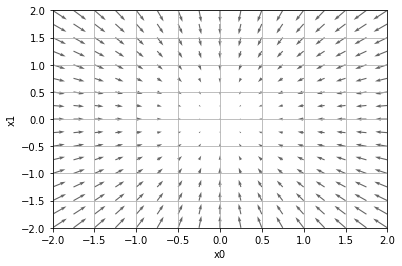

In [41]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

def function_2(x): #我的優化目標函數
    return x[0]**2 + x[1]**2
    #或是return np.sum(x**2)
    
    
def numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x) #產生和x相同形狀的陣列
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h) #中央差分
        
        x[idx] = tmp_val  # 恢復原值
        
    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()

    grad = numerical_gradient(function_2, np.array([X, Y]).T).T

    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()
    
# 由圖可知，梯度是指函數的「最低位置( 最小值 )」。


### 4.4.1 梯度法
從目前的位置往梯度的方向，只前進一定的距離，接著同樣計算出移動後位置的梯度，在朝著梯度方向前進，重複這種步驟，往梯度方向移動。這種反覆往梯度方向移動，逐漸減少函數值的方法，稱為**梯度法( gradient method )**，我們現在來實現他。


In [6]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        
        
        return x
    

在這裡，引數f是要最佳化的函數，init_x是預設值，lr是代表learning rate的學習率，step_num是用梯度法重複的次數。函數的梯度是由numerical_gradient(f, x)計算出來，在梯度乘上學習率的值，進行更新處理，並且重複step_num設定的次數。<br><br>

接著，我們利用梯度法求出$f(x_0,x_1)=x^2_0+x^2_1$的最小值。<br>


In [7]:
import numpy as np

def function_2(x):
    return np.sum(x**2)

# 學習率太大的範例：lr = 10
init_x = np.array([-3, 4])
tem = gradient_descent(function_2, init_x=init_x, lr = 10, step_num=100)
print(tem)


[ 249997 -349996]


如同這個實驗結果所示，學習率太大，會往大數值擴散。因此我們須適當地設定學習率。<br><br>

向學習率這種參數稱為**超參數( $hyperparameter$ )**。與權重、偏權值參數不同，這需要人工設定的參數。一般而言，這種超參數必須以各種數值進行測試，找出可以順利學習的結果。<br><br>

我們來看看梯度下降的過程吧~


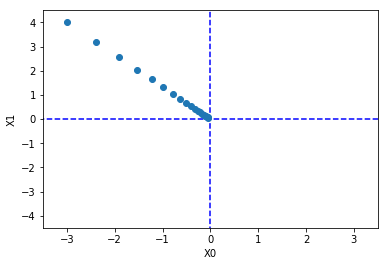

In [70]:
import numpy as np
import matplotlib.pylab as plt
# from gradient_2d import numerical_gradient

def numerical_gradient(f, X):
    if X.ndim == 1:
        return numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_no_batch(f, x)
        
        return grad

def gradient_descent(f, init_x, lr=0.001, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()



在神經網路的學習中，也必須計算出梯度。我們已**W**代表為權重的神經網路，以L代表損失函數。<br><br>
接下來，我們來簡單執行神經網路梯度的計算。


In [9]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dl_ex.common.functions import softmax, cross_entropy_error
from dl_ex.common.gradient import numerical_gradient

class simpleNet: #2輸出x3輸入的神經網路
    def __init__(self):
        self.W = np.random.randn(2, 3) #以常態分配初始化
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t) #x為輸入變數，t為正確答的標籤
        
        return loss

# 接下來，我們試著執行simpleNet類別
net = simpleNet()
print(net.W, '\n') #權重參數

x = np.array ([.6, .9]) #2個輸入值
p = net.predict(x)
print(p) #z
print(np.argmax(p)) #最大值的索引值 

t = np.array([0, 1, 0]) #正確答案的標籤
print(net.loss(x, t))


[[-0.34043642  1.20448088  1.44894279]
 [-0.54244058  1.68266245  0.96231321]] 

[-0.69245837  2.23708473  1.73544757]
1
0.5061906872318946


接下來要使numerical_gradient(f, x)計算梯度，這裡定義的f(w)函數，其引數w設定為虛擬。因為numerical_gradient(f, x)在內部執行f(x)，所以要定義f(w)，以取得整合性。


In [ ]:
def f(W):
    return net.loss(x, t)
dW = numerical_gradient(f, net.W)
print(dW)


由印出的結果可以得知，$W_{11}$約為0.02，代表只增加$h$，損失函數的值會增加0.2$h$，由此可以，$W_{23}$(約0.75)所貢獻的程度為最大。


## 4.5 執行學習演算法
與神經網路的學習有關的基本知識已全部說明完畢。到此為止，陸續出現了「損失函數」、「小批次」、「梯度」、「梯度下降法」等重要關鍵自，因此以下要確認神經網路的學習步驟，順便當作複習。<br><br>

神經網路示按造以下4個步驟來學習。<br>
* 前提<br>
神經網路擁有適合的權重與偏權值，為了符合訓練資料，而調整權重與偏權值，這就稱作「學習」。神經網路是按造以下4步驟來「學習」的。<br><br>

* 步驟一( 小批次 )<br>
從訓練資料中，隨機挑選部分資料。挑選出來的資料就稱為小批次，這個步驟是以減少小批次的損失函數值為「目標」。<br><br>

* 步驟二( 計算梯度 )<br>
為了減少小批次的損失函數，計算出各權重參數的梯度。梯度會顯示出損失函數值減少最多的「方向」。<br><br>

* 步驟三( 更新參數 )<br>
權重參數只往梯度方向進行微量更新。<br><br>

*步驟四( 重複 )<br>
重複執行以上步驟。<br><br>

需注意的是，這些資料是隨機挑選出來，在當作小批次，因此稱為「隨機梯度下降法(SGD)」。<br><br>

接著，我們使用MNIST資料集來學習(隱藏層為一層)。


In [10]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex'))  
from dl_ex.common.functions import *
from dl_ex.common.gradient import numerical_gradient

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, 
                 weight_init_std=0.01):
        # 權重初始化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        
        self.params['b1'] = np.zeros(hidden_size)
        
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    # x:輸入資料, t:訓練資料
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
    
    # x:輸入資料, t:訓練資料
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    

### 說明
為了說明，我們先上個圖<br>
表4.1 TwolayerNet使用的參數<br>
![TwolayerNet使用的參數](./img/4.5.1.PNG)<br>
表4.2 TwolayerNet類別的方法<br>
![TwolayerNet類別的方法](./img/4.5.2.PNG)<br><br>

TwolayerNet類別是實例變數，擁有params與grads等字典變數。params變數儲存了權重參數，例如第1層的權重參數是以Numpy陣列儲存於params['W1']中。另外，第1層的偏權值可以用params['b1]的方式來存取。以下來看一個範例。<br><br>

{note} <br> 
* 類別變數用「類別名稱.變數名稱」就能存取
* 而實例變數需要建構出物件才能以「物件變數名稱.變數名稱」 才能存取


In [6]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape) #(784, 100))
print(net.params['b1'].shape) #(100, )
print(net.params['W2'].shape) #(100, 10)
print(net.params['b2'].shape) #(10, )


(784, 100)
(100,)
(100, 10)
(10,)


上面的params變數中，儲存了這個神經網路所需的「全部參數」。儲存在params變數中的權重參數，會用在推論處理( 正向(傳播)處理 )上。以下是推論處理可以用來執行的方式。


In [7]:
import numpy as np
x = np.random.rand(100, 784) #虛擬的輸入資料 (100張)
y = net.predict(x)


在grad變數中，以對應params變數的方式，儲存各參數的梯度。例如，使用numerical_gradient()方法計算梯度，就會將梯度資料儲存在grads變數中。


In [9]:
import numpy as np
x = np.random.rand(100, 784) #虛擬的輸入資料 (100張影像，每張影像為28x28 pixels)
t = np.random.rand(100, 10) #虛擬正確答案標籤(100張影像，10個手寫數字)

grads = net.numerical_gradient(x, t) #計算梯度

print(net.params['W1'].shape) #(784, 100))
print(net.params['b1'].shape) #(100, )
print(net.params['W2'].shape) #(100, 10)
print(net.params['b2'].shape) #(10, )


(784, 100)
(100,)
(100, 10)
(10,)


其中，我們numerical_gradient(self, x, t)是使用數值微分，算出參數的梯度。下一章，我們將說明一個更為快速，求出梯度的手法，稱為「誤差反向傳播法」。


### 4.5.2 執行小批次學習
神經網路的學習，是使用前面說明過的小批次學習來處理。這次，我們以小批次為對象，利用梯度法更新參數。接下來，以TwoLayerNet類別為對象，使用MNIST資料集進行學習。


In [12]:
import numpy as np
from dl_ex.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten = True, one_hot_label=True)

train_loss_list = []

#超參數
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

network = TwoLayerNet(input_size= 784, hidden_size=50, output_size=10)

for i in range(iters_num): #學習四步驟
    #取得小批次
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #計算梯度
    grad = network.numerical_gradient(x_batch, t_batch)
        # grad = network.gradient(x_batch, t_batch) #高速版!
    
    #更新參數
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    #紀錄學習過程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    

KeyboardInterrupt: 

### 解說
假設小批量大小為100，每次從60000個訓練資料中，隨機取出100個資料(影像資料與正確答案標籤資料)。接著，以100個小批次為對象，計算梯度，利用SGD更新參數。假設梯度法的更新次數( iters數 )為10000次，根據每次更新，計算出訓練資料的損失函數，再將這個值新增在陣列中。我們將更新過程用圖表來表達如下：


### 4.5.3 利用測試資料進行評估
根據上圖結果，可以確認重複學習，損失函數的值會逐漸下降。可是，這裡所謂的損失函數值，正確來說是「對應訓練資料小批次的損失函數」。訓練資料的損失函數值減少，表示神經網路的學習順利進行。但是光從這個結果來看，無法確定其他資料集也能發揮相同程度的影響力。<br><br>

在神經網路中，必須確認能不能正確辨識訓練資料以外的資料，亦即，要確認有沒有發生「過度學習」的情況。<br><br>

原本神經網路學習目標就是學會一般化能力。如果要評估神經網路的一般化能力，必須使用不包含訓練資料的資料。因此，利用以下的執行方式，在學習的過程中，定期以訓練資料以及測試資料為對象，紀錄辨識準確度。這裡依照每個循環週期(epoch)紀錄訓練資料與測試資料的辨識準確度。


In [ ]:

import sys, os
sys.path.append(os.path.abspath('./dl_ex'))  #載入父目錄
import numpy as np
import matplotlib.pyplot as plt
from dl_ex.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

#超參數
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 每1 epoch的重複次數
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):#學習四步驟
    #取得小批次
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #計算梯度
    grad = network.numerical_gradient(x_batch, t_batch)
        # grad = network.gradient(x_batch, t_batch) #高速版!
    
    #更新參數
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    #紀錄學習過程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    #計算1 epoch的辨識準確度
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 繪圖功能
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()



train acc, test acc | 0.09066666666666667, 0.0898


## 4.6 重點整理
由上圖可以看到，訓練準確度與測試準確度沒有差別( 兩條線幾乎重疊 )。因此，可以得知，這次學習並沒有出現過度學習的情形。<br><br>

本章節說明了神經網路的學習。剛開始，神經網路為了學習，而導入損失函數這個「指標」。以損失函數為基準，找出讓損失函數變得最小的權重參數，就是神經網路的學習目標。另外，還說明了盡可能找出最小損失函數值，利用函數斜率的梯度法。<br>

### 本章學到的重點
* ML使用的資料集分成訓練資料與測試資料。
* 利用訓練資料學習，再以測試資料評估學習模型的「一般化能力」。
* 神經網路的學習是以損失函數為「指標」，更新權重參數，縮小損失函數的值。
* 更新權重參數時，利用權重參數的梯度，重複進行往梯度方向更新權重值的步驟。
* 利用給予微小值的差分來計算微分，稱作數值微分。
* 利用數值微分可以計算出權重參數的梯度，但會有些微誤差。
* 利用數值微分來運算比較花時間，但是執行方法簡單。然而，下一章要執行的誤差反向傳播法略為複雜，卻能快速計算出梯度。
